# Exercise 1 : connect to the oscilloscope

To start using the oscilloscope, let’s copy some functionalities and try to understand them by
executing

In [ ]:
import pyvisa

rm = pyvisa.ResourceManager()       # sans '@py' car on uutlise NI-VISA
ID=rm.list_resources()
print(ID)


Osci = rm.open_resource(ID[0])
# To select a single channel (1 or 2) permanently you can use this line
# it allows you to not write CHAN2 at every call

Osci.write(':MEAS:SOUR:CHAN2')
data = []
# Measure settings
# You can measure different parameters one by one)
data.append(Osci.query(':MEAS:Item? VPP'))
data.append(Osci.query(':MEAS:Item? VAVG'))
data.append(Osci.query(':MEAS:Item? PER'))
data.append(Osci.query(':MEAS:SOUR?'))
data.append(Osci.query(':CHAN1:SCAL?'))
data.append(Osci.query(':FUNC:WREC:FEND?'))
Osci.write(':MATH:FFT:SOUR CHAN1')
Osci.write(':MATH:OPER FFT')
Osci.write(':MATH:DISP ON')
data.append(Osci.query(':LAN:VISA?'))
# Warning to Measure 'MAth' should be off
# either it might not work, try it yourself! do you get data 8?
Osci.write(':MATH:OPER FFT')
Osci.write(':MATH:DISP OFF')
#measure the frequency of the signal
Osci.write(':MEAS:COUN:SOUR CHAN1')
data.append(Osci.query(':MEAS:COUN:VAL?'))
print(data)
Osci.close()


('USB0::0x1AB1::0x04CE::DS1ZC212301128::INSTR',)
['9.600000e-01\n', '1.396320e-01\n', '9.9E37\n', 'CHAN1\n', '1.000000e+00\n', '5000\n', 'TCPIP::141.1.168.192::INSTR\n', '6.4899549e+03\n']


# Exercise 2 - oscilloscope

1) Create a program that can interface the oscilloscope and plot VRM S as a function of time.
hints, to help as:
- a) Use numpy
- b) use Use MatplotLib



('USB0::0x1AB1::0x04CE::DS1ZC212301128::INSTR',)


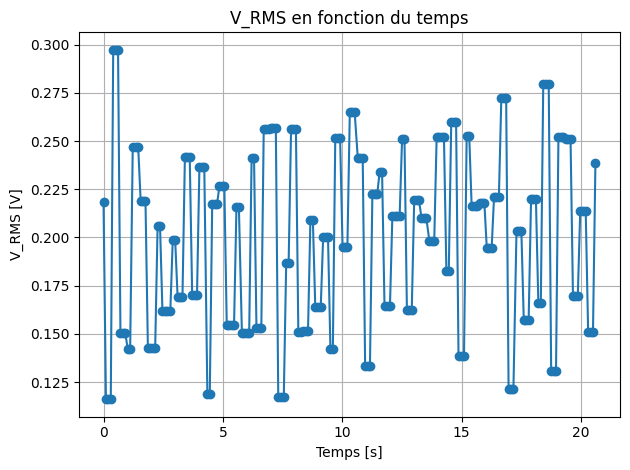

In [ ]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import time

# Initialisation
rm = pyvisa.ResourceManager()       # sans '@py' car on uutlise NI-VISA
ID=rm.list_resources()
print(ID)
#-------------------------------
# Paramètres de la mesure
N_POINTS = 200          # nombre de mesures de VRMS
MEAS_INTERVAL = 0.1     # intervalle entre mesures (en secondes)

# ============================  
# Connexion à l'oscilloscope
rm = pyvisa.ResourceManager()
scope = rm.open_resource(ID[0]) # à adapter selon l'adresse VISA de ton scope


# ============================
# Configuration de la mesure
# À adapter selon ton oscillo !
# Exemples typiques de commandes SCPI :
# - Keysight / Agilent : 
#     :MEASure:VRMS? CHANnel1
# - Rigol :
#     :MEASure:ITEM VRMS,CHAN1
#
# Ici on suppose une commande générique de type :MEASure:VRMS? CHANnel1

CHANNEL = "CHANnel1"

# ============================
# Boucle de mesure
times = np.zeros(N_POINTS)
vrms_values = np.zeros(N_POINTS)

t0 = time.time()
for i in range(N_POINTS):
    # temps relatif (en secondes)
    times[i] = time.time() - t0

    # Demande de mesure VRMS au scope
    scope.write(f":MEASure:VRMS? {CHANNEL}")   
    answer = scope.read()                     
    try:
        vrms_values[i] = float(answer)
    except ValueError:
        # si la mesure n'est pas valide / NAN, on peut mettre NaN
        vrms_values[i] = np.nan

    # attend avant la prochaine mesure
    time.sleep(MEAS_INTERVAL)

# On ferme proprement
scope.close()
rm.close()

# ============================
# Affichage des résultats
plt.figure()
plt.plot(times, vrms_values, marker="o")
plt.xlabel("Temps [s]")
plt.ylabel("V_RMS [V]")
plt.title("V_RMS en fonction du temps")
plt.grid(True)
plt.tight_layout()
plt.show()


('USB0::0x1AB1::0x04CE::DS1ZC212301128::INSTR',)


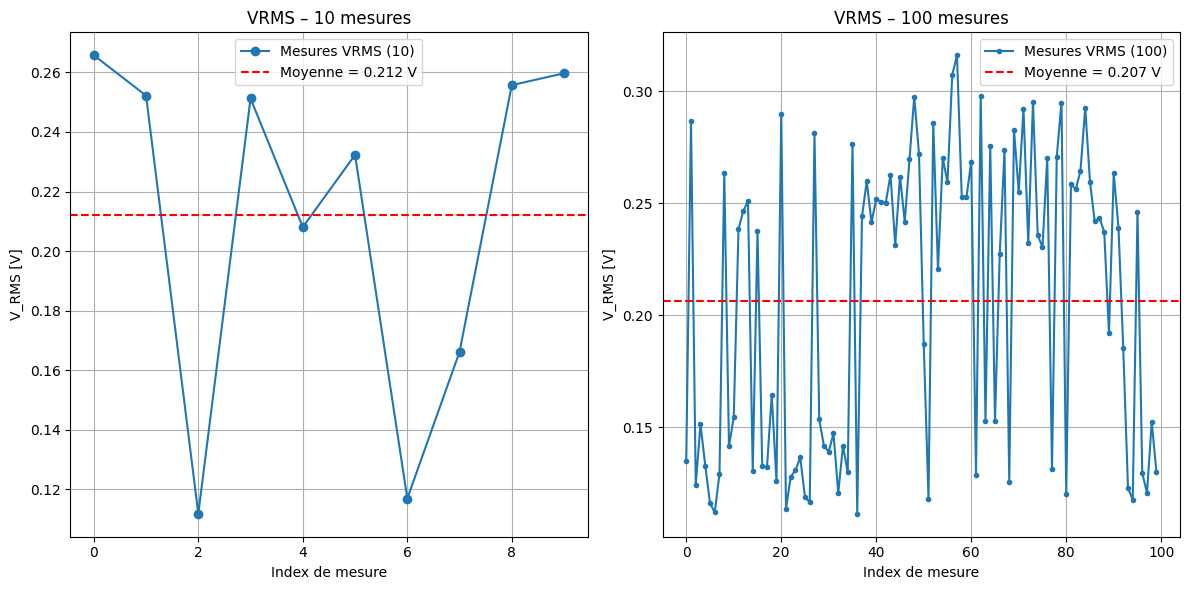

In [20]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import time

# Initialisation
rm = pyvisa.ResourceManager()       # sans '@py' car on uutlise NI-VISA
ID=rm.list_resources()
print(ID)
#----------


# ============================
# Paramètres
CHANNEL = "CHAN1"                           # Nom du canal
WAIT = 0.5                                  # 500 ms entre mesures

# Commande VRMS à adapter selon ton oscilloscope :
# Keysight   :  ":MEASure:VRMS? CHANnel1"
# Rigol      :  ":MEASure:ITEM VRMS,CHAN1"
MEASURE_CMD = f":MEASure:VRMS? {CHANNEL}"

# ============================
# Connexion VISA
rm = pyvisa.ResourceManager()
scope = rm.open_resource(ID[0])
scope.timeout = 5000  # 5 secondes

# ============================
# Fonction de mesure VRMS
def measure_vrms(n):
    values = []
    for _ in range(n):
        scope.write(MEASURE_CMD)
        resp = scope.read()

        try:
            vrms = float(resp)
        except:
            vrms = np.nan

        values.append(vrms)
        time.sleep(WAIT)

    return np.array(values)

# ============================
# Acquisition 10 mesures
vrms_10 = measure_vrms(10)
mean_10 = np.mean(vrms_10)

# ============================
# Acquisition 100 mesures
vrms_100 = measure_vrms(100)
mean_100 = np.mean(vrms_100)

scope.close()
rm.close()

# ============================
# Affichage des résultats
plt.figure(figsize=(12,6))

# ---- 10 mesures ----
plt.subplot(1, 2, 1)
plt.plot(vrms_10, marker="o", linestyle="-", label="Mesures VRMS (10)")
plt.axhline(mean_10, color="red", linestyle="--", label=f"Moyenne = {mean_10:.3f} V")
plt.title("VRMS – 10 mesures")
plt.xlabel("Index de mesure")
plt.ylabel("V_RMS [V]")
plt.grid(True)
plt.legend()

# ---- 100 mesures ----
plt.subplot(1, 2, 2)
plt.plot(vrms_100, marker=".", linestyle="-", label="Mesures VRMS (100)")
plt.axhline(mean_100, color="red", linestyle="--", label=f"Moyenne = {mean_100:.3f} V")
plt.title("VRMS – 100 mesures")
plt.xlabel("Index de mesure")
plt.ylabel("V_RMS [V]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# 3) Let’s start reducing the value of waiting time. Compute the minimum waiting time and
with it the sampling rate of VRM S on the oscilloscope.